Named Entity Recognition (NER)

By completing this notebook, you will be able to: 

- Design the architecture of a neural network, train it, and test it. 
- Process features and represents them
- Understand word padding
- Implement LSTMs
- Test with your own sentence

## Outline
- [Introduction](#0)
- [Part 1:  Exploring the data](#1)
    - [1.1  Importing the Data](#1.1)
    - [1.2  Data generator](#1.2)
		- [Exercise 01](#ex01)
- [Part 2:  Building the model](#2)
	- [Exercise 02](#ex02)
- [Part 3:  Train the Model ](#3)
	- [Exercise 03](#ex03)
- [Part 4:  Compute Accuracy](#4)
	- [Exercise 04](#ex04)
- [Part 5:  Testing with your own sentence](#5)


### Importing files

Before starting please import the TP files via the link below:

https://drive.google.com/drive/folders/1nW2JpUX648G4g4d9mv09lEpjWtNXlEYy?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


<a name="0"></a>
# Introduction

We first start by defining named entity recognition (NER). NER is a subtask of information extraction that locates and classifies named entities in a text. The named entities could be organizations, persons, locations, times, etc. 

For example:

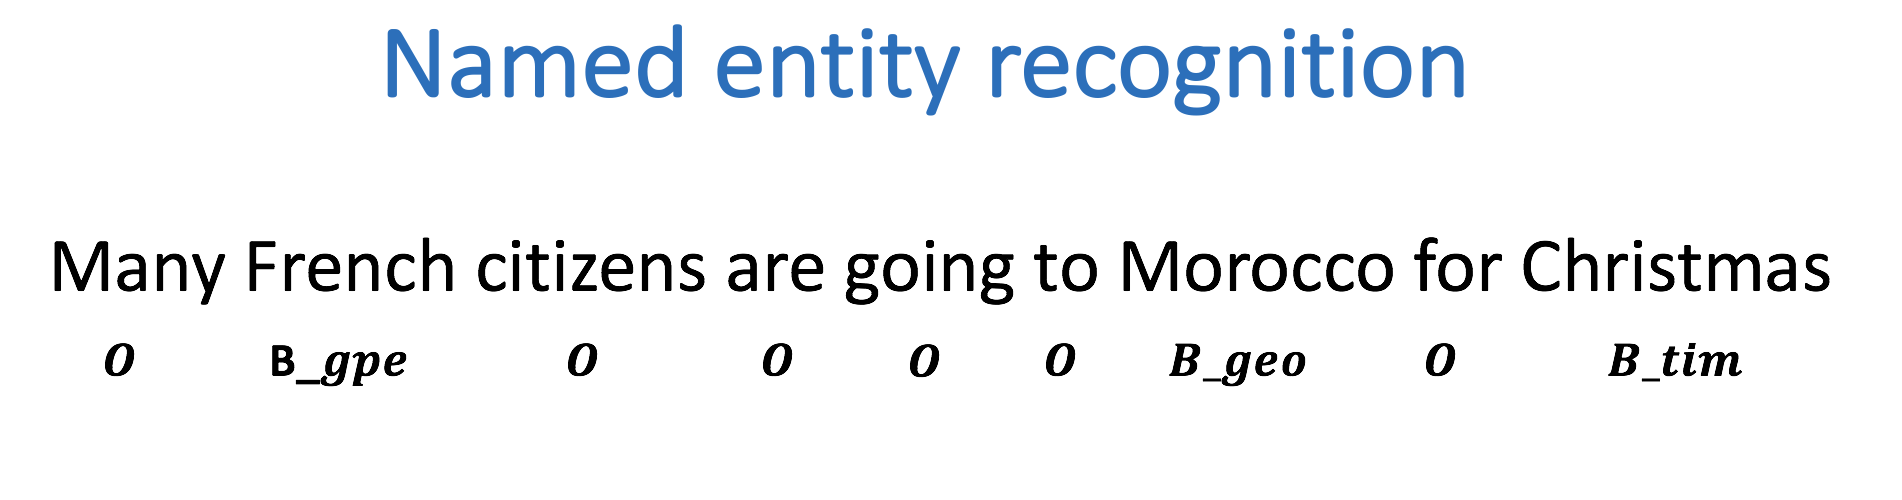


Is labeled as follows: 

- French: geopolitical entity
- Morocco: geographic entity 
- Christmas: time indicator

Everything else that is labeled with an `O` is not considered to be a named entity. In this notebook, you will train a named entity recognition system that could be trained in a few seconds (on a GPU) and will get around 75% accuracy. Then, you will load in the exact version of your model, which was trained for a longer period of time. You could then evaluate the trained version of your model to get 96% accuracy! Finally, you will be able to test your named entity recognition system with your own sentence.

In [ ]:
!pip -q install trax==1.3.1

In [ ]:
import trax 
from trax import layers as tl
import os 
import numpy as np
import pandas as pd


from gdrive.MyDrive.TP_11.utils import get_params, get_vocab
import random as rnd

# set random seeds to make this notebook easier to replicate
trax.supervised.trainer_lib.init_random_number_generators(33)

DeviceArray([ 0, 33], dtype=uint32)

<a name="1"></a>
# Part 1:  Exploring the data

We will be using a dataset from Kaggle, which we will preprocess for you. The original data consists of four columns, the sentence number, the word, the part of speech of the word, and the tags.  A few tags you might expect to see are: 

* geo: geographical entity
* org: organization
* per: person 
* gpe: geopolitical entity
* tim: time indicator
* art: artifact
* eve: event
* nat: natural phenomenon
* O: filler word


In [ ]:
# display original kaggle data
data = pd.read_csv("gdrive/MyDrive/TP_11/ner_dataset.csv", encoding = "ISO-8859-1") 
train_sents = open('gdrive/MyDrive/TP_11/data/small/train/sentences.txt', 'r').readline()
train_labels = open('gdrive/MyDrive/TP_11/data/small/train/labels.txt', 'r').readline()
print('SENTENCE:', train_sents)
print('SENTENCE LABEL:', train_labels)
print('ORIGINAL DATA:\n', data.head(5))
del(data, train_sents, train_labels)

SENTENCE: Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

SENTENCE LABEL: O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

ORIGINAL DATA:
     Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O


<a name="1.1"></a>
## 1.1  Importing the Data

In this part, we will import the preprocessed data and explore it.

In [ ]:
vocab, tag_map = get_vocab('gdrive/MyDrive/TP_11/data/large/words.txt', 'gdrive/MyDrive/TP_11/data/large/tags.txt')
t_sentences, t_labels, t_size = get_params(vocab, tag_map, 'gdrive/MyDrive/TP_11/data/large/train/sentences.txt', 'gdrive/MyDrive/TP_11/data/large/train/labels.txt')
v_sentences, v_labels, v_size = get_params(vocab, tag_map, 'gdrive/MyDrive/TP_11/data/large/val/sentences.txt', 'gdrive/MyDrive/TP_11/data/large/val/labels.txt')
test_sentences, test_labels, test_size = get_params(vocab, tag_map, 'gdrive/MyDrive/TP_11/data/large/test/sentences.txt', 'gdrive/MyDrive/TP_11/data/large/test/labels.txt')

`vocab` is a dictionary that translates a word string to a unique number. Given a sentence, you can represent it as an array of numbers translating with this dictionary. The dictionary contains a `<PAD>` token. 

When training an LSTM using batches, all your input sentences must be the same size. To accomplish this, you set the length of your sentences to a certain number and add the generic `<PAD>` token to fill all the empty spaces. 

In [ ]:
# vocab translates from a word to a unique number
print('vocab["the"]:', vocab["the"])
# Pad token
print('padded token:', vocab['<PAD>'])

vocab["the"]: 9
padded token: 35180


The tag_map corresponds to one of the possible tags a word can have. Run the cell below to see the possible classes you will be predicting. The prepositions in the tags mean:
* I: Token is inside an entity.
* B: Token begins an entity.

In [ ]:
print(tag_map)

{'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8, 'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}


So the coding scheme that tags the entities is a minimal one where B- indicates the first token in a multi-token entity, and I- indicates one in the middle of a multi-token entity. If you had the sentence 

**"Sharon flew to Miami on Friday"**

the outputs would look like:

```
Sharon B-per
flew   O
to     O
Miami  B-geo
on     O
Friday B-tim
```

your tags would reflect three tokens beginning with B-, since there are no multi-token entities in the sequence. But if you added Sharon's last name to the sentence: 

**"Sharon Floyd flew to Miami on Friday"**

```
Sharon B-per
Floyd  I-per
flew   O
to     O
Miami  B-geo
on     O
Friday B-tim
```

then your tags would change to show first "Sharon" as B-per, and "Floyd" as I-per, where I- indicates an inner token in a multi-token sequence.

In [ ]:
# Exploring information about the data
print('The number of outputs is tag_map', len(tag_map))
# The number of vocabulary tokens (including <PAD>)
g_vocab_size = len(vocab)
print(f"Num of vocabulary words: {g_vocab_size}")
print('The vocab size is', len(vocab))
print('The training size is', t_size)
print('The validation size is', v_size)
print('An example of the first sentence is', t_sentences[0])
print('An example of its corresponding label is', t_labels[0])

The number of outputs is tag_map 17
Num of vocabulary words: 35181
The vocab size is 35181
The training size is 33570
The validation size is 7194
An example of the first sentence is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 1, 16, 17, 18, 19, 20, 21]
An example of its corresponding label is [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]


So you can see that we have already encoded each sentence into a tensor by converting it into a number. We also have 16 possible classes, as shown in the tag map.


<a name="1.2"></a>
## 1.2  Data generator

In python, a generator is a function that behaves like an iterator. It will return the next item. Here is a [link](https://wiki.python.org/moin/Generators) to review python generators. 

In many AI applications it is very useful to have a data generator. You will now implement a data generator for our NER application.

<a name="ex01"></a>
### Exercise 01

**Instructions:** Implement a data generator function that takes in `batch_size, x, y, pad, shuffle` where x is a large list of sentences, and y is a list of the tags associated with those sentences and pad is a pad value. Return a subset of those inputs in a tuple of two arrays `(X,Y)`. Each is an array of dimension (`batch_size, max_len`), where `max_len` is the length of the longest sentence *in that batch*. You will pad the X and Y examples with the pad argument. If `shuffle=True`, the data will be traversed in a random form.

**Details:**

This code as an outer loop  
```
while True:  
...  
yield((X,Y))  
```

Which runs continuously in the fashion of generators, pausing when yielding the next values. We will generate a batch_size output on each pass of this loop.    

It has two inner loops. 
1. The first stores in temporal lists the data samples to be included in the next batch, and finds the maximum length of the sentences contained in it. By adjusting the length to include only the size of the longest sentence in each batch, overall computation is reduced. 

2. The second loop moves those inputs from the temporal list into NumPy arrays pre-filled with pad values.

There are three slightly out of the ordinary features. 
1. The first is the use of the NumPy `full` function to fill the NumPy arrays with a pad value. See [full function documentation](https://numpy.org/doc/1.18/reference/generated/numpy.full.html).

2. The second is tracking the current location in the incoming lists of sentences. Generators variables hold their values between invocations, so we create an `index` variable, initialize to zero, and increment by one for each sample included in a batch. However, we do not use the `index` to access the positions of the list of sentences directly. Instead, we use it to select one index from a list of indexes. In this way, we can change the order in which we traverse our original list, keeping untouched our original list.  

3. The third also relates to wrapping. Because `batch_size` and the length of the input lists are not aligned, gathering a batch_size group of inputs may involve wrapping back to the beginning of the input loop. In our approach, it is just enough to reset the `index` to 0. We can re-shuffle the list of indexes to produce different batches each time.

In [ ]:
def data_generator(batch_size, x, y, pad, shuffle=False, verbose=False):
    '''
      Input: 
        batch_size - integer describing the batch size
        x - list containing sentences where words are represented as integers
        y - list containing tags associated with the sentences
        shuffle - Shuffle the data order
        pad - an integer representing a pad character
        verbose - Print information during runtime
      Output:
        a tuple containing 2 elements:
        X - np.ndarray of dim (batch_size, max_len) of padded sentences
        Y - np.ndarray of dim (batch_size, max_len) of tags associated with the sentences in X
    '''
    
    # count the number of lines in data_lines
    num_lines = len(x)
    
    # create an array with the indexes of data_lines that can be shuffled
    lines_index = [*range(num_lines)]
    
    # shuffle the indexes if shuffle is set to True
    if shuffle:
        rnd.shuffle(lines_index)
    
    index = 0 # tracks current location in x, y
    while True:
        buffer_x = [0] * batch_size # Temporal array to store the raw x data for this batch
        buffer_y = [0] * batch_size # Temporal array to store the raw y data for this batch
                
  ### START CODE HERE (Replace instances of 'None' with your code) ###
        
        # Copy into the temporal buffers the sentences in x[index : index + batch_size] 
        # along with their corresponding labels y[index : index + batch_size]
        # Find maximum length of sentences in x[index : index + batch_size] for this batch. 
        # Reset the index if we reach the end of the data set, and shuffle the indexes if needed.
        max_len = 0
        for i in range(batch_size):
             # if the index is greater than or equal to the number of lines in x
            if index >= num_lines:
                # then reset the index to 0
                index = None
                # re-shuffle the indexes if shuffle is set to True
                if shuffle:
                    rnd.shuffle(None)
            
            # The current position is obtained using `lines_index[index]`
            # Store the x value at the current position into the buffer_x
            buffer_x[i] = None
            
            # Store the y value at the current position into the buffer_y
            buffer_y[i] = None
            
            lenx = None    #length of current x[]
            if lenx > max_len:
                max_len = None                   #max_len tracks longest x[]
            
            # increment index by one
            index += None


        # create X,Y, NumPy arrays of size (batch_size, max_len) 'full' of pad value
        X = None
        Y = None

        # copy values from lists to NumPy arrays. Use the buffered values
        for i in range(batch_size):
            # get the example (sentence as a tensor)
            # in `buffer_x` at the `i` index
            x_i = None
            
            # similarly, get the example's labels
            # in `buffer_y` at the `i` index
            y_i = None
            
            # Walk through each word in x_i
            for j in range(len(x_i)):
                # store the word in x_i at position j into X
                X[i, j] = None
                
                # store the label in y_i at position j into Y
                Y[i, j] = None

    ### END CODE HERE ###
        if verbose: print("index=", index)
        yield((X,Y))

In [ ]:
batch_size = 5
mini_sentences = t_sentences[0: 8]
mini_labels = t_labels[0: 8]
dg = data_generator(batch_size, mini_sentences, mini_labels, vocab["<PAD>"], shuffle=False, verbose=True)
X1, Y1 = next(dg)
X2, Y2 = next(dg)
print(Y1.shape, X1.shape, Y2.shape, X2.shape)
print(X1[0][:], "\n", Y1[0][:])

index= 5
index= 2
(5, 30) (5, 30) (5, 30) (5, 30)
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14     9    15     1    16    17    18    19    20    21
 35180 35180 35180 35180 35180 35180] 
 [    0     0     0     0     0     0     1     0     0     0     0     0
     1     0     0     0     0     0     2     0     0     0     0     0
 35180 35180 35180 35180 35180 35180]


**Expected output:**   
```
index= 5
index= 2
(5, 30) (5, 30) (5, 30) (5, 30)
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14     9    15     1    16    17    18    19    20    21
 35180 35180 35180 35180 35180 35180] 
 [    0     0     0     0     0     0     1     0     0     0     0     0
     1     0     0     0     0     0     2     0     0     0     0     0
 35180 35180 35180 35180 35180 35180]  
```

<a name="2"></a>
# Part 2:  Building the model

You will now implement the model. You will be using Google's TensorFlow. Your model will be able to distinguish the following:

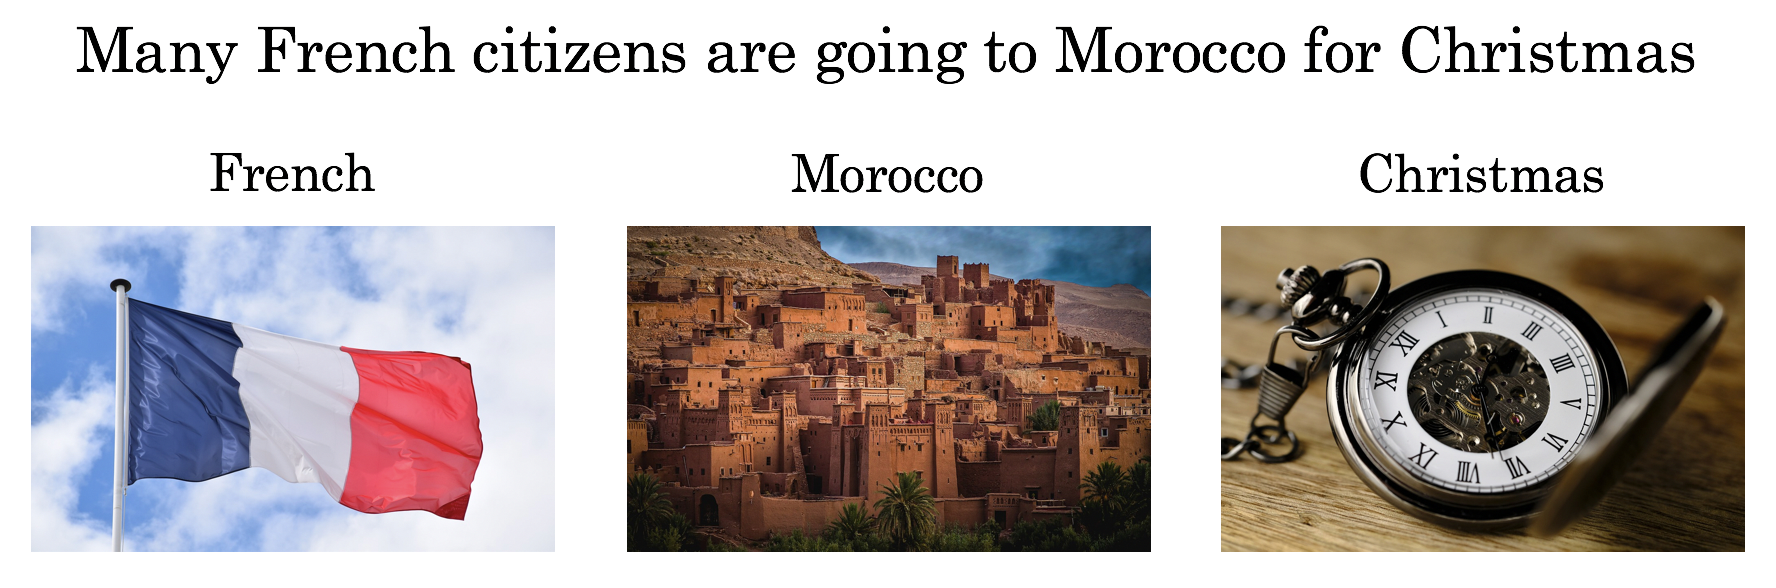

The model architecture will be as follows: 

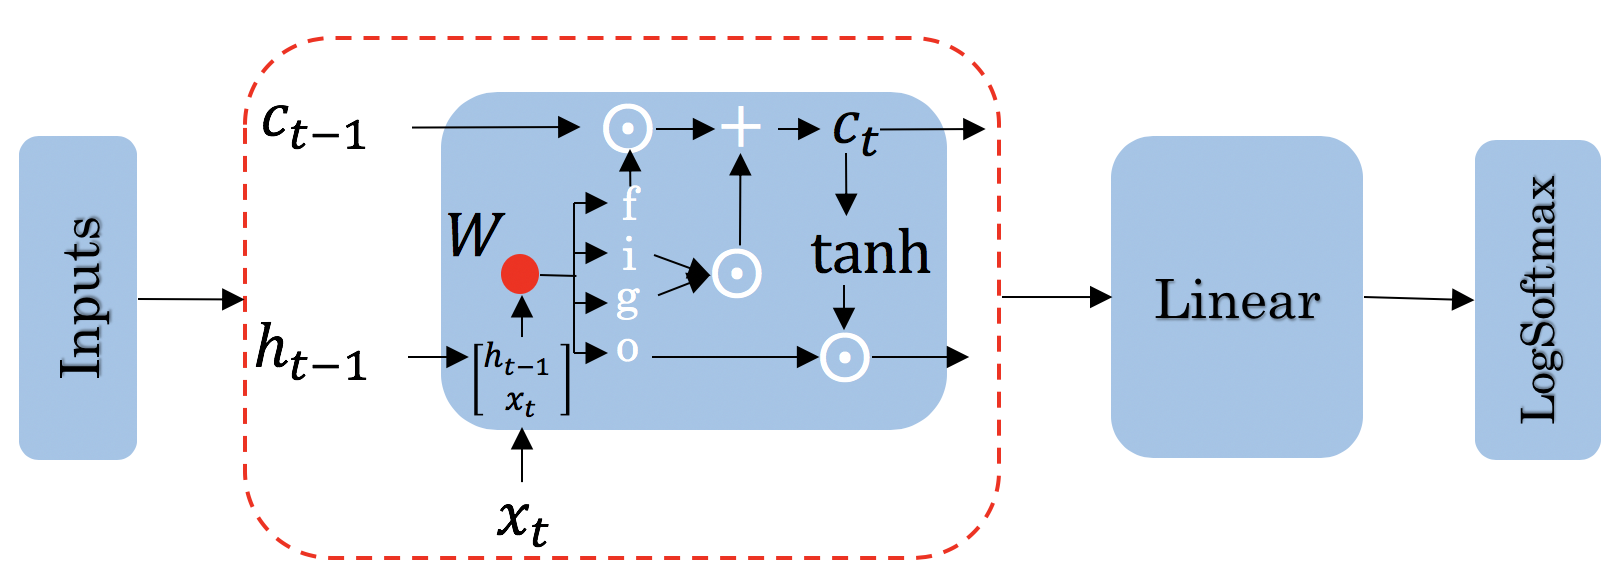


Concretely: 

* Use the input tensors you built in your data generator
* Feed it into an Embedding layer, to produce more semantic entries
* Feed it into an LSTM layer
* Run the output through a linear layer
* Run the result through a log softmax layer to get the predicted class for each word.

Good news! We won't make you implement the LSTM unit drawn above. However, we will ask you to build the model. 

<a name="ex02"></a>
### Exercise 02

**Instructions:** Implement the initialization step and the forward function of your Named Entity Recognition system.  
Please utilize help function e.g. `help(tl.Dense)` for more information on a layer
   
- [tl.Serial](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/combinators.py#L26): Combinator that applies layers serially (by function composition).
    - You can pass in the layers as arguments to `Serial`, separated by commas. 
    - For example: `tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))` 


-  [tl.Embedding](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L113): Initializes the embedding. In this case it is the dimension of the model by the size of the vocabulary. 
    - `tl.Embedding(vocab_size, d_feature)`.
    - `vocab_size` is the number of unique words in the given vocabulary.
    - `d_feature` is the number of elements in the word embedding (some choices for a word embedding size range from 150 to 300, for example).
    

-  [tl.LSTM](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/rnn.py#L87):`Trax` LSTM layer of size d_model. 
    - `LSTM(n_units)` Builds an LSTM layer of n_cells.



-  [tl.Dense](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L28):  A dense layer.
    - `tl.Dense(n_units)`: The parameter `n_units` is the number of units chosen for this dense layer.  


- [tl.LogSoftmax](https://github.com/google/trax/blob/1372b903bb66b0daccee19fd0b1fdf44f659330b/trax/layers/core.py#L242): Log of the output probabilities.
    - Here, you don't need to set any parameters for `LogSoftMax()`.
 

**Online documentation**

- [tl.Serial](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#module-trax.layers.combinators)

- [tl.Embedding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding)

-  [tl.LSTM](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.rnn.LSTM)

-  [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense)

- [tl.LogSoftmax](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax)    

In [ ]:
def NER(vocab_size=35181, d_model=50, tags=tag_map):
    '''
      Input: 
        vocab_size - integer containing the size of the vocabulary
        d_model - integer describing the embedding size
      Output:
        model - a trax serial model
    '''
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    model = tl.Serial(
      None, # Embedding layer
      None, # LSTM layer
      None, # Dense layer with len(tags) units
      None  # LogSoftmax layer
      )
      ### END CODE HERE ###
    return model

In [ ]:
# initializing your model
model = NER()
# display your model
print(model)

Serial[
  Embedding_35181_50
  LSTM_50
  Dense_17
  LogSoftmax
]


**Expected output:**  
```
Serial[
  Embedding_35181_50
  LSTM_50
  Dense_17
  LogSoftmax
]
```  


<a name="3"></a>
# Part 3:  Train the Model 

This section will train your model.

Before you start, you need to create the data generators for training and validation data. It is important that you mask padding in the loss weights of your data, which can be done using the `id_to_mask` argument of `trax.supervised.inputs.add_loss_weights`.

In [ ]:
from trax.supervised import training

rnd.seed(33)

batch_size = 64

# Create training data, mask pad id=35180 for training.
train_generator = trax.supervised.inputs.add_loss_weights(
    data_generator(batch_size, t_sentences, t_labels, vocab['<PAD>'], True),
    id_to_mask=vocab['<PAD>'])

# Create validation data, mask pad id=35180 for training.
eval_generator = trax.supervised.inputs.add_loss_weights(
    data_generator(batch_size, v_sentences, v_labels, vocab['<PAD>'], True),
    id_to_mask=vocab['<PAD>'])

<a name='3.1'></a>
### 3.1 Training the model

You will now write a function that takes in your model and trains it.

You will first create the [TrainTask](https://trax-ml.readthedocs.io/en/stable/trax.supervised.html#trax.supervised.training.TrainTask) and [EvalTask](https://trax-ml.readthedocs.io/en/stable/trax.supervised.html#trax.supervised.training.EvalTask) using your data generator. Then you will use the `training.Loop` to train your model.

<a name="ex03"></a>
### Exercise 03

**Instructions:** Implement the `train_model` program below to train the neural network above. Here is a list of things you should do: 
- Create the trainer object by calling [`trax.supervised.training.Loop`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.Loop) and pass in the following:

    - model = [NER](#ex02)
    - [training task](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.TrainTask) that uses the train data generator defined in the cell above
        - loss_layer = [tl.CrossEntropyLoss()](https://github.com/google/trax/blob/22765bb18608d376d8cd660f9865760e4ff489cd/trax/layers/metrics.py#L71)
        - optimizer = [trax.optimizers.Adam(0.01)](https://github.com/google/trax/blob/03cb32995e83fc1455b0c8d1c81a14e894d0b7e3/trax/optimizers/adam.py#L23)
    - [evaluation task](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.EvalTask) that uses the validation data generator defined in the cell above
        - metrics for `EvalTask`: `tl.CrossEntropyLoss()` and `tl.Accuracy()`
        - in `EvalTask` set `n_eval_batches=10` for better evaluation accuracy
    - output_dir = output_dir

You'll be using a [cross entropy loss](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.CrossEntropyLoss), with an [Adam optimizer](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html#trax.optimizers.adam.Adam). Please read the [trax](https://trax-ml.readthedocs.io/en/latest/trax.html) documentation to get a full understanding. The [trax GitHub](https://github.com/google/trax) also contains some useful information and a link to a colab notebook.

In [ ]:
def train_model(NER, train_generator, eval_generator, train_steps=1, output_dir='model'):
    '''
    Input: 
        NER - the model you are building
        train_generator - The data generator for training examples
        eval_generator - The data generator for validation examples,
        train_steps - number of training steps
        output_dir - folder to save your model
    Output:
        training_loop - a trax supervised training Loop
    '''
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    train_task = training.TrainTask(
      None, # A train data generator
      loss_layer = None, # A cross-entropy loss function
      optimizer = None,  # The adam optimizer
    )

    eval_task = training.EvalTask(
      labeled_data = None, # A labeled data generator
      metrics = [None, None], # Evaluate with cross-entropy loss and accuracy
      n_eval_batches = None # Number of batches to use on each evaluation
    )

    training_loop = training.Loop(
        None, # A model to train
        None, # A train task
        eval_task = None, # The evaluation task
        output_dir = None) # The output directory

    # Train with train_steps
    training_loop.run(n_steps = None)
    ### END CODE HERE ###
    return training_loop

On your local machine, you can run this training for 1000 train_steps and get your own model. This training takes about 5 to 10 minutes to run.

In [ ]:
train_steps = 100            
!rm -f 'model/model.pkl.gz'  # Remove old model.pkl if it exists

# Train the model
training_loop = train_model(NER(), train_generator, eval_generator, train_steps)

Step      1: train CrossEntropyLoss |  3.29934025
Step      1: eval  CrossEntropyLoss |  2.27930446
Step      1: eval          Accuracy |  0.22279499
Step    100: train CrossEntropyLoss |  0.61237401
Step    100: eval  CrossEntropyLoss |  0.37608686
Step    100: eval          Accuracy |  0.90983243


**Expected output (Approximately)**

```
...
Step      1: train CrossEntropyLoss |  2.94375849
Step      1: eval  CrossEntropyLoss |  1.93172036
Step      1: eval          Accuracy |  0.78727312
Step    100: train CrossEntropyLoss |  0.57727730
Step    100: eval  CrossEntropyLoss |  0.36356260
Step    100: eval          Accuracy |  0.90943187
...
```
This value may change between executions, but it must be around 90% of accuracy on train and validations sets, after 100 training steps.

We have trained the model longer, and we give you such a trained model. In that way, we ensure you can continue with the rest of the notebook even if you had some troubles up to here, and also we are sure that everybody will get the same outputs for the last example. However, you are free to try your model, as well. 

In [ ]:
# loading in a pretrained model..
model = NER()
model.init(trax.shapes.ShapeDtype((1, 1), dtype=np.int32))

# Load the pretrained model
model.init_from_file('gdrive/MyDrive/TP_11/model.pkl.gz', weights_only=True)

<a name="4"></a>
# Part 4:  Compute Accuracy

You will now evaluate in the test set. Previously, you have seen the accuracy on the training set and the validation (noted as eval) set. You will now evaluate on your test set. To get a good evaluation, you will need to create a mask to avoid counting the padding tokens when computing the accuracy. 

<a name="ex04"></a>
### Exercise 04

**Instructions:** Write a program that takes in your model and uses it to evaluate on the test set. You should be able to get an accuracy of 95%.  



<details>    
<summary>
    <font size="3" color="darkgreen"><b>More Detailed Instructions </b></font>
</summary>

* *Step 1*: model(sentences) will give you the predicted output. 

* *Step 2*: Prediction will produce an output with an added dimension. For each sentence, for each word, there will be a vector of probabilities for each tag type. For each sentence,word, you need to pick the maximum valued tag. This will require `np.argmax` and careful use of the `axis` argument.
* *Step 3*: Create a mask to prevent counting pad characters. It has the same dimension as output. An example below on matrix comparison provides a hint.
* *Step 4*: Compute the accuracy metric by comparing your outputs against your test labels. Take the sum of that and divide by the total number of **unpadded** tokens. Use your mask value to mask the padded tokens. Return the accuracy. 
</detail>

In [ ]:
#Example of a comparision on a matrix 
a = np.array([1, 2, 3, 4])
a == 2

array([False,  True, False, False])

In [ ]:
# create the evaluation inputs
x, y = next(data_generator(len(test_sentences), test_sentences, test_labels, vocab['<PAD>']))
print("input shapes", x.shape, y.shape)

input shapes (7194, 70) (7194, 70)


In [ ]:
# sample prediction
tmp_pred = model(x)
print(type(tmp_pred))
print(f"tmp_pred has shape: {tmp_pred.shape}")

<class 'jax.interpreters.xla._DeviceArray'>
tmp_pred has shape: (7194, 70, 17)


Note that the model's prediction has 3 axes: 
- the number of examples
- the number of words in each example (padded to be as long as the longest sentence in the batch)
- the number of possible targets (the 17 named entity tags).

In [ ]:
def evaluate_prediction(pred, labels, pad):
    """
    Inputs:
        pred: prediction array with shape 
            (num examples, max sentence length in batch, num of classes)
        labels: array of size (batch_size, seq_len)
        pad: integer representing pad character
    Outputs:
        accuracy: float
    """
    ### START CODE HERE (Replace instances of 'None' with your code) ###
## step 1 ##
    outputs = None
    print("outputs shape:", outputs.shape)

## step 2 ##
    mask = None
    print("mask shape:", mask.shape, "mask[0][20:30]:", mask[0][20:30])
## step 3 ##
    accuracy = None
    ### END CODE HERE ###
    return accuracy


In [ ]:
accuracy = evaluate_prediction(model(x), y, vocab['<PAD>'])
print("accuracy: ", accuracy)

outputs shape: (7194, 70)
mask shape: (7194, 70) mask[0][20:30]: [ True  True  True False False False False False False False]
accuracy:  0.9543761


**Expected output (Approximately)**   
```
outputs shape: (7194, 70)
mask shape: (7194, 70) mask[0][20:30]: [ True  True  True False False False False False False False]
accuracy:  0.9543761281155191
```


<a name="5"></a>
# Part 5:  Testing with your own sentence


Below, you can test it out with your own sentence! 

In [ ]:
# This is the function you will be using to test your own sentence.
def predict(sentence, model, vocab, tag_map):
    s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
    batch_data = np.ones((1, len(s)))
    batch_data[0][:] = s
    sentence = np.array(batch_data).astype(int)
    output = model(sentence)
    outputs = np.argmax(output, axis=2)
    labels = list(tag_map.keys())
    pred = []
    for i in range(len(outputs[0])):
        idx = outputs[0][i] 
        pred_label = labels[idx]
        pred.append(pred_label)
    return pred

In [ ]:
# Try the output for the introduction example
#sentence = "Many French citizens are goin to visit Morocco for summer"
#sentence = "Sharon Floyd flew to Miami last Friday"

# New york times news:
sentence = "Peter Navarro, the White House director of trade and manufacturing policy of U.S, said in an interview on Sunday morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall, though he said it wouldn’t necessarily come"
s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
predictions = predict(sentence, model, vocab, tag_map)
for x,y in zip(sentence.split(' '), predictions):
    if y != 'O':
        print(x,y)

Peter B-per
Navarro, I-per
White B-org
House I-org
Sunday B-tim
morning I-tim
White B-org
House I-org
coronavirus B-tim
fall, B-tim


** Expected Results **

```
Peter B-per
Navarro, I-per
White B-org
House I-org
Sunday B-tim
morning I-tim
White B-org
House I-org
coronavirus B-tim
fall, B-tim
```